In [1]:
import data, training, eval, process_data
import wandb, torch

import numpy as np

In [2]:
wandb.login()

#Laptop
#root = "C:/Users/20182573/Documents/CityScapes"

#Desktop
root = 'E:/Cityscapes'
gta_root = 'E:/GTA5'


lr_rate = 3e-4
epochs = 25
batch_size = 8
subsize = (256, 512)
weight_decay = 1e-5
wenb = True
train = True
verbose = False
save = True
load = False
GTA = True


weights = torch.tensor([0.0007, 0.0044, 0.0012, 0.0262, 0.0238, 0.0268, 0.0602, 0.0311, 0.0017,
        0.0203, 0.0069, 0.0237, 0.1081, 0.0040, 0.0973, 0.1133, 0.1122, 0.2590,
        0.0791])

weights = torch.nn.functional.pad(weights, (0, 34 - weights.size(0)), mode='constant', value=0)



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: svenbbs. Use `wandb login --relogin` to force relogin


In [3]:
if GTA:
    train_set, val_set = data.loadGTAData(root=gta_root, subsize=subsize,verbose=True)
else:
    train_set, val_set = data.loadData(root=root, subsize=subsize,verbose=True)

    
train_dl, val_dl = data.getDataLoader(train_set=train_set, val_set=val_set, batch_size=batch_size)

24966
Size of the training set: 19973
Size of the validation set: 4993


In [4]:
model, loss_fn, optimizer, device = training.buildModel(lr_rate=lr_rate,weights=weights, weight_decay=weight_decay, verbose=True)

Working on device: cuda:0


In [5]:
if wenb:

    run = wandb.init(
        # Set the project where this run will be logged
        project="CS_challenge", name="5.1",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": {lr_rate},
            "epochs": {epochs},
            "Batch_size": {batch_size},
            "model version": 1.0,
            "resize": {subsize},
            "Optimizer": 'Adam',
            "Weights": True,
            "Weight decay": weight_decay,
            "GTA": {GTA} ,
        },
    )

In [6]:
def freeze_layers():
    # Freeze layers
    for param in model.e1.parameters():
        param.requires_grad = False
    for param in model.e2.parameters():
        param.requires_grad = False
    for param in model.e3.parameters():
        param.requires_grad = False
    for param in model.e4.parameters():
        param.requires_grad = False
    for param in model.b.parameters():
        param.requires_grad = False

In [7]:
if train:
    if load:
        model.load_state_dict(torch.load('../Trained_models/5-0-1.pth'))
        #freeze_layers()

    training.trainModel(train_dl,val_dl,model,loss_fn,optimizer,device,epochs,wenb,val_set,subsize,verbose)
else:
    model.load_state_dict(torch.load('../Trained_models/4-1-2.pth'))
    


Done!


In [8]:
averageIOU = eval.calculateIOU(val_set, model, device, subsize, False)


if wenb:
   wandb.log({"Average IOU(full)": averageIOU})

c:\Users\Sven\Documents\GitHub\CS_challenge\Guided\eval.py:120: RuntimeWarning: invalid value encountered in scalar divide
  class_iou = np.sum(intersection) / np.sum(union)


In [9]:
if wenb:
    run.finish()

Average IOU(full),▁
average_validation_loss,█▆▄▄▄▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▅▆▅▃▃▄▄▃▃▄▄▂▂▂▄▁▂▂▂▂▃▂▂▅▂▃▁▂▂▂▃▂▂▂▂▂▃▁
validation_loss,██▄▅▅▄▆▅▅▅▄▅▃▃▃▂▂▆▂▁▁▃▃▄▃▃▄▂▃▃▃▂▃▁▂▂▂▂▃▂
x_train,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
x_val,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Average IOU(full),0.0033
average_validation_loss,0.4452
epoch,25
train_loss,0.42232


In [10]:
if save:
    torch.save(model.state_dict(), "model.pth")

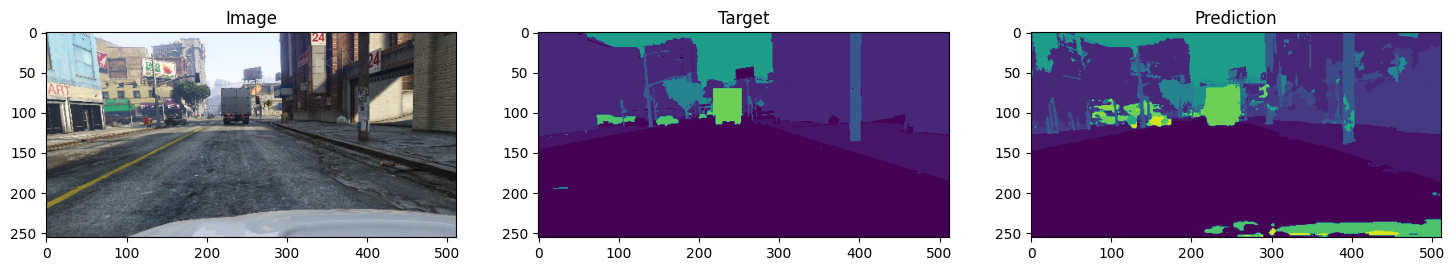

In [11]:
image, target = eval.getRandomImageAndTarget(val_set)
prediction = eval.predict(image, model, device, subsize)
eval.showImageTargetAndPrediction(image, target, prediction)